Over Sample and undersample? Bootstrap? repeated holdout? Stratefied k Fold Scikit learn has weights feature

We are interested in precision for no default, recall for default

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)


#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

#Create a separate dataset in case we need to come back to original
dfsub = df

#We will not need these attributes. We are using log of them instead.
del dfsub['LIMIT_BAL']
del dfsub['PAY_AMT1']
del dfsub['PAY_AMT2']
del dfsub['PAY_AMT3']
del dfsub['PAY_AMT4']
del dfsub['PAY_AMT5']
del dfsub['PAY_AMT6']

#We found in Lab1 that there is high correlation between BILL Amount and Pay 
##Amounts so ignore bill amount for now
del dfsub['BILL_AMT1']
del dfsub['BILL_AMT2']
del dfsub['BILL_AMT3']
del dfsub['BILL_AMT4']
del dfsub['BILL_AMT5']
del dfsub['BILL_AMT6']

- Bagging (Random Forests)
- Boosting (Gradient of Error)
- Statistical Comparison Questions

Number of Observations 30000


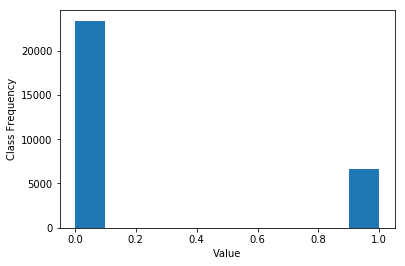

In [2]:
print ('Number of Observations', len(dfsub.default))

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(dfsub.default )
plt.xlabel('Value')
plt.ylabel('Class Frequency')
plt.show()

In [3]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy 0.8165333333333333


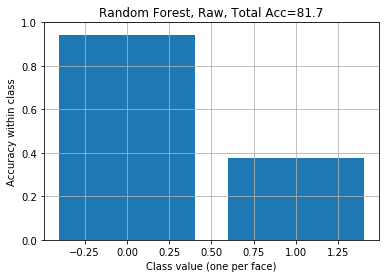

Wall time: 31.4 s


In [4]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn import metrics as mt

# create variables we are more familiar with
if 'default' in dfsub:
    y = dfsub['default'].values
    del dfsub['default'] 
    X = dfsub.values
    yhat = np.zeros(y.shape) # we will fill this with predictions
    
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#1000 81
#400 = 81.7
#200 = 81.8
#20 = 81.1

#https://www.youtube.com/watch?v=DQC_YE3I5ig

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


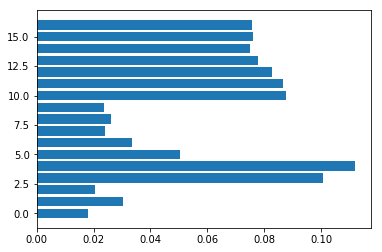

Generalization score estimate from training data 0.816229028554498


In [5]:
print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)

We thisnk that we can improve by SMOTe oversampling the defaults. We dont want to undersampl the non-defaults because precision is important for no default.

Try more folds

Accuracy 0.8162666666666667


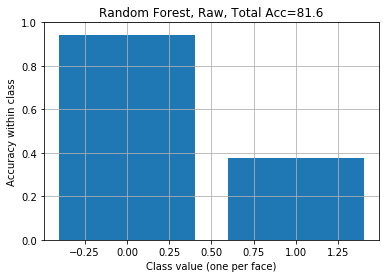

Wall time: 5min 53s


In [8]:
%%time
cv = StratifiedKFold(n_splits=100)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#1000 81
#400 = 81.7
#200 = 81.8
#20 = 81.1

#https://www.youtube.com/watch?v=DQC_YE3I5ig

Try Balanced Subsample

Accuracy 0.8170333333333333


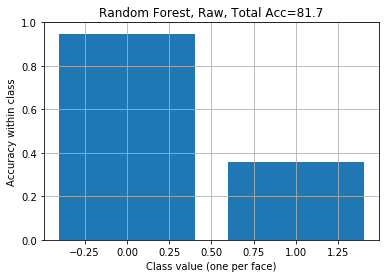

Wall time: 48.8 s


In [9]:
%%time
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(class_weight='balanced_subsample',max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#1000 81
#400 = 81.7
#200 = 81.8
#20 = 81.1

#https://www.youtube.com/watch?v=DQC_YE3I5ig

Try different weights

Accuracy 0.8153666666666667


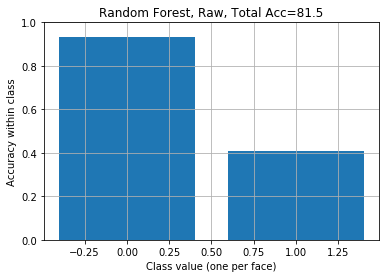

Wall time: 38 s


In [10]:
%%time
weights ={1:.1, 0: .9}
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(class_weight=weights,max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#weights ={1:.1, 0: .9} = 81.4

#https://www.youtube.com/watch?v=DQC_YE3I5ig